# Exploratory Data Analysis

 В данном разделе мы проведем исследовательский анализ данных (EDA) для понимания структуры и особенностей данных, которые мы будем использовать для обучения модели. Мы будем использовать библиотеку pandas для анализа данных и matplotlib для визуализации.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Датасет представляет из себя набор видео с выступлениями длиною 30-32с, прилагающиеся к ним транскрипты и результаты обработки видео с помощью библиотек. В результате обработки мы получили 3 файла с данными:
- **dataset_audio.csv** - обработка аудио, использовали библиотеки librosa, webrtcvad, parselmouth;
- **dataset_facial_expression.csv** - обработка видео, в частности, мимики, использовали библиотеки mediapipe, deepface  OpenFace;
- **dataset_gesture.csv** - обработка видео, в частности, жестов, использовали библиотеку mediapipe.

Полученные данные объединили в один файл **dataset_final.csv**, который и будем использовать для обучения модели.

In [2]:
data = pd.read_csv('D:\\course_project\\data\\datasets\\dataset_final.csv')

In [3]:
data.fillna(0, inplace=True)

---

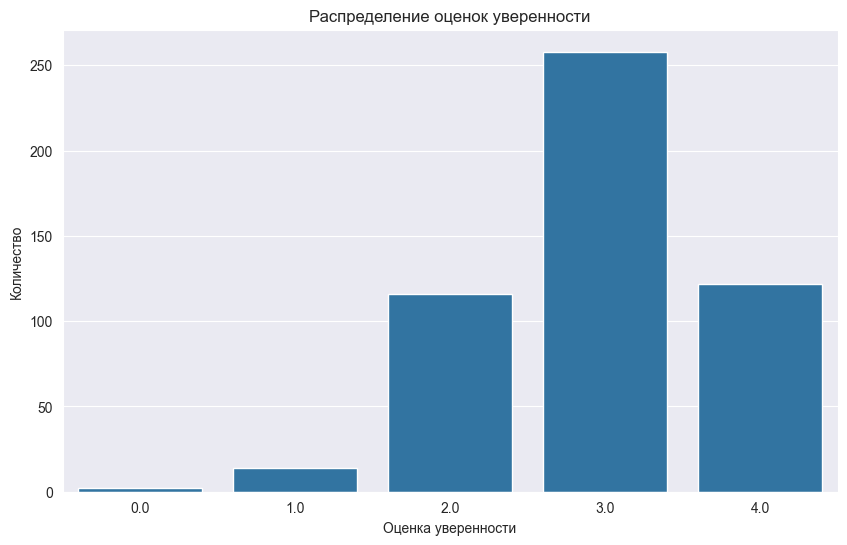

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='confidence_assessment')
plt.title('Распределение оценок уверенности')
plt.xlabel('Оценка уверенности')
plt.ylabel('Количество')
plt.show()

---

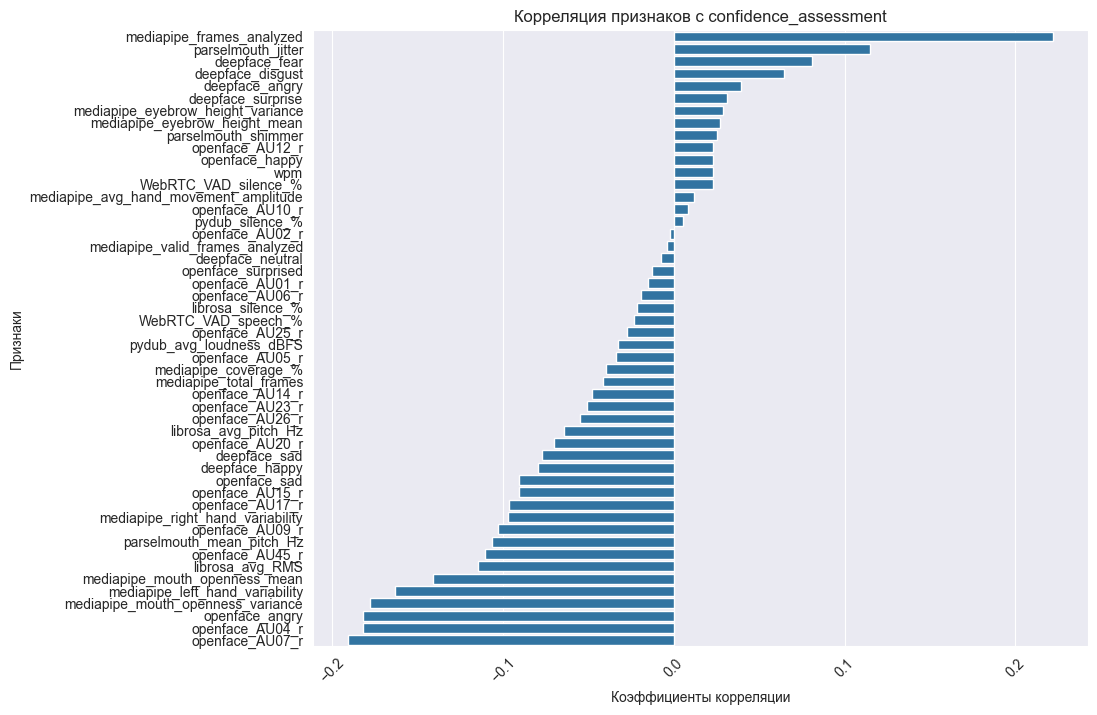

In [5]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop('confidence_assessment')

correlations = data[numerical_features].corrwith(data['confidence_assessment']).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(y=correlations.index, x=correlations.values)
plt.title('Корреляция признаков с confidence_assessment')
plt.xlabel('Коэффициенты корреляции')
plt.ylabel('Признаки')
plt.xticks(rotation=45)
plt.show()

Как видно из графика, наибольшее влияние на оценку уверенности оказывают следующие признаки:
- mediapipe_frames_analyzed,
- mediapipe_total_frames,
- parselmouth_jitter,
- openface_AU07,
- openface_AU04,
- openface_angry.

---

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = data[numerical_features]

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_scaled)

components = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=numerical_features
)

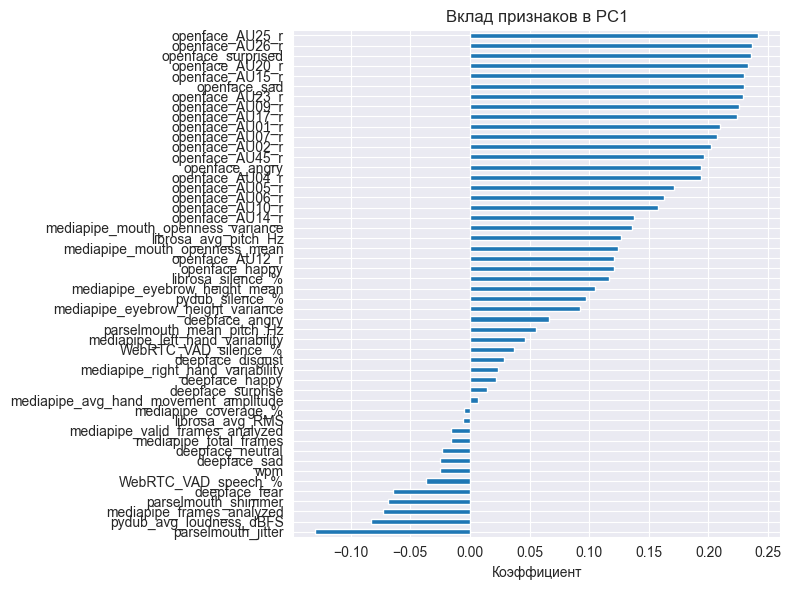

In [7]:
components["PC1"].sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Вклад признаков в PC1")
plt.xlabel("Коэффициент")
plt.grid(True)
plt.tight_layout()
plt.show()

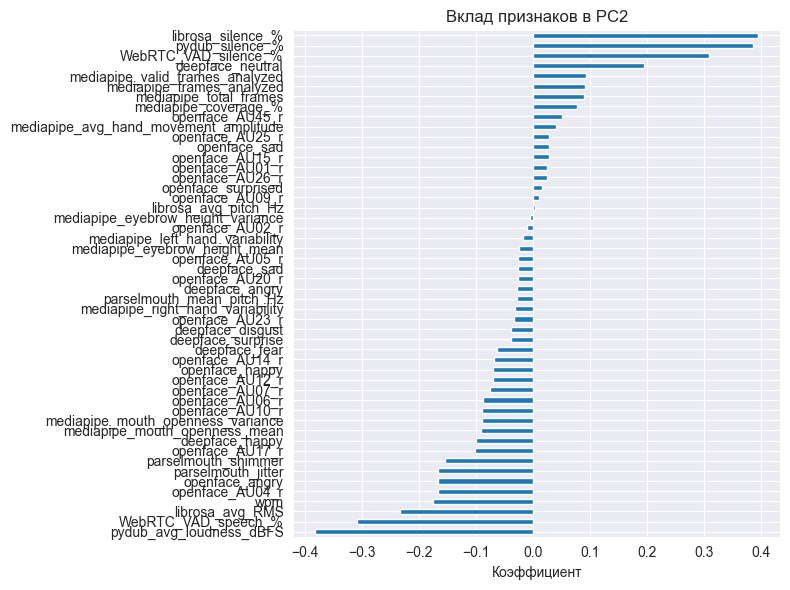

In [8]:
components["PC2"].sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Вклад признаков в PC2")
plt.xlabel("Коэффициент")
plt.grid(True)
plt.tight_layout()
plt.show()

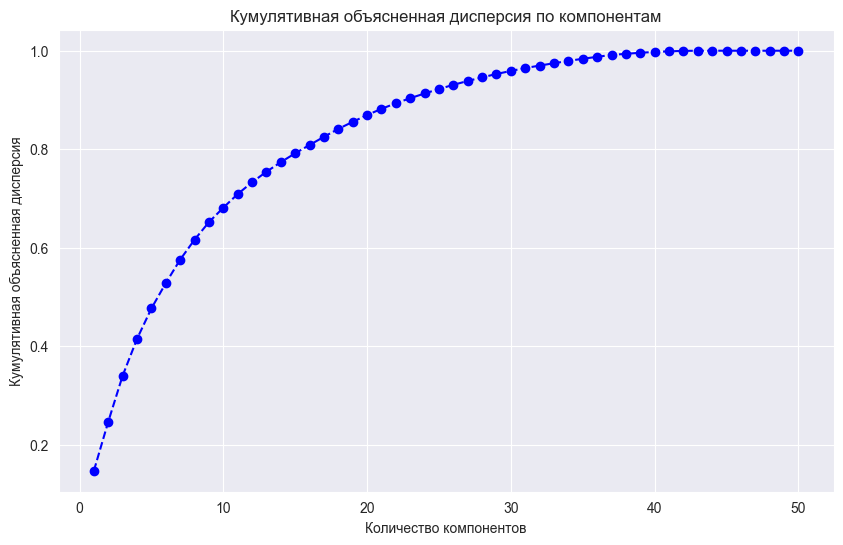

Для объяснения 90.0% дисперсии достаточно использовать 23 компоненты.


In [9]:
pca = PCA()
pca.fit(X_scaled)

eigenvalues = pca.explained_variance_

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), cumulative_variance, marker='o', color='b', linestyle='--')
plt.title('Кумулятивная объясненная дисперсия по компонентам')
plt.xlabel('Количество компонентов')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.show()

threshold = 0.9  # Уровень дисперсии, который мы хотим объяснить
num_components_to_keep = np.argmax(cumulative_variance >= threshold) + 1
print(f"Для объяснения {threshold * 100}% дисперсии достаточно использовать {num_components_to_keep} компоненты.")

---

In [10]:
data = pd.read_csv('D:\\course_project\\data\\datasets\\dataset_final.csv')

In [11]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['confidence_assessment', 'segment_name'])
y = data['confidence_assessment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

In [12]:
# %pip install optuna catboost

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

f1_micro_scorer = make_scorer(f1_score, average='micro')

def objective(trial):
    params = {
        'cat_features': cat_features,
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'iterations': trial.suggest_int('iterations', 400, 1000, step=100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1.0, 10.0),
        # 'auto_class_weights': 'Balanced',
        'loss_function': 'MultiClass',
        'verbose': 0,
        'random_seed': 42
    }

    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_micro_scorer)
    return scores.mean()

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)

D:\course_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-13 20:48:52,054] A new study created in memory with name: no-name-88dcc466-22b5-4e6a-a77f-8421db8a18f3
D:\course_project\venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
[I 2025-05-13 20:50:46,521] Trial 0 finished with value: 0.5207166516109606 and parameters: {'depth': 4, 'learning_rate': 0.06286384639008231, 'l2_leaf_reg': 5.008397670703905, 'iterations': 800, 'bagging_temperature': 0.7403266560230554, 'random_strength': 2.4611313651795172}. Best is trial 0 with value: 0.5207166516109606.
D:\course_project\venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in

KeyboardInterrupt: 

In [14]:
print("Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

print(f"Лучшее значение F1-макро: {study.best_value:.4f}")

Лучшие параметры:
depth: 5
learning_rate: 0.044639387722674936
l2_leaf_reg: 2.5605162133305304
iterations: 400
bagging_temperature: 0.11686878381381005
random_strength: 9.036552627028026
Лучшее значение F1-макро: 0.5377
